# Set Up the Environment

### Install Dependencies

In [ ]:
# Install PyTorch and dependencies
%pip install torch torchvision

# Install Hugging Face Transformers for model loading
%pip install transformers

# Install dataset tools
%pip install datasets
# for image Processiing
%pip install opencv-python

### Importing Libraries and Drive Files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from transformers import pipeline
from transformers import AutoModelForDepthEstimation
import time
import PIL
from PIL import Image
import requests
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Define Needed Classes & Functions

Class for Depth Model

In [3]:
class DepthModel(nn.Module):
    def __init__(self, mod, features_to_extract=None):
        super().__init__()
        self.model = mod
        self.eval()
        self.features_to_extract = features_to_extract

    def forward(self, x):
        outputs = self.model(x)
        predicted_depth = outputs.predicted_depth

        extracted_features = []
        if self.features_to_extract is not None and outputs.hidden_states is not None:
            for i in self.features_to_extract:
                if 0 <= i < len(outputs.hidden_states):
                    extracted_features.append(outputs.hidden_states[i])
                else:
                    print(f"Warning: Feature index {i} out of bounds for teacher model.")

        if self.features_to_extract is not None:
            return predicted_depth, extracted_features
        return predicted_depth


Class for Dataset Loading & Preprocessing

In [4]:
class UnlabeledImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(('png', 'jpg', 'JPG'))]
        print(f"Found {len(self.image_paths)} images in {root_dir}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        return image

Distillation Loss

In [5]:
class DepthDistillationLoss(nn.Module):
    def __init__(self, lambda_depth=1.0, lambda_features=0.0):
        super().__init__()
        self.lambda_depth = lambda_depth # Weight for depth map loss
        self.lambda_features = lambda_features # Weight for feature loss
        self.mse_depth_loss = nn.MSELoss() # Mean Absolute Error for depth maps
        self.mse_feature_loss = nn.MSELoss() # Mean Squared Error for features

    def forward(self, student_outputs, teacher_outputs):
        # student_outputs and teacher_outputs if tupless (depth_map, [features])
        student_depth = student_outputs[0] if isinstance(student_outputs, tuple) else student_outputs
        teacher_depth = teacher_outputs[0] if isinstance(teacher_outputs, tuple) else teacher_outputs

        total_loss = torch.tensor(0.0, device=student_depth.device)

        # 1. Depth Map Loss (MSE)
        if self.lambda_depth > 0:
            loss_depth = self.mse_depth_loss(student_depth, teacher_depth)
            total_loss += self.lambda_depth * loss_depth

        # 2. Feature Loss (MSE) - if features are provided
        if self.lambda_features > 0 and isinstance(student_outputs, tuple) and isinstance(teacher_outputs, tuple):
            student_features = student_outputs[1]
            teacher_features = teacher_outputs[1]
            if len(student_features) != len(teacher_features):
                raise ValueError("Number of student and teacher feature lists must match.")

            loss_features = 0.0
            valid_features_count = 0
            for sf, tf in zip(student_features, teacher_features):
                # Only attempt interpolation and feature loss if both student and teacher features are 4D
                if sf.ndim == 4 and tf.ndim == 4:
                    # Ensure feature maps are of compatible sizes if different layers have different resolutions
                    # Interpolate student feature to teacher feature size
                    if sf.shape != tf.shape:
                        # Explicitly provide the target size as a tuple (Height, Width)
                        target_size = (tf.shape[2], tf.shape[3])
                        sf = F.interpolate(sf, size=target_size, mode='bilinear', align_corners=False)
                    loss_features += self.mse_feature_loss(sf, tf)
                    valid_features_count += 1

            if valid_features_count > 0:
                 total_loss += self.lambda_features * (loss_features / valid_features_count) # Average feature loss for valid features
            else:
                print("Warning: No valid 4D features found for feature loss calculation.")


        return total_loss

The Training Function

In [6]:
def train_knowledge_distillation(teacher, student, dataloader, criterion, optimizer, epochs, device):
    teacher.eval() # Teacher should always be in evaluation mode
    student.train() # Student in training mode

    print(f"Starting Knowledge Distillation Training on {device}...")
    models = []
    x = 0
    for epoch in range(epochs):
        running_loss = 0.0
        start_time = time.time()

        for batch_idx, inputs in enumerate(dataloader):
            inputs = inputs.to(device)

            optimizer.zero_grad()

            # Forward pass with Teacher model (no_grad as teacher is fixed)
            with torch.no_grad():
                teacher_outputs = teacher(inputs) # Returns depth map and/or features

            # Forward pass with Student model
            student_outputs = student(inputs) # Returns depth map and/or features

            # Calculate distillation loss
            loss = criterion(student_outputs, teacher_outputs)

            # Backpropagation and Optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if (batch_idx + 1) % 50 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {running_loss / (batch_idx+1):.4f}")

        epoch_loss = running_loss / len(dataloader)
        end_time = time.time()
        print(f"Epoch {epoch+1} finished. Avg Loss: {epoch_loss:.4f}, Time: {end_time - start_time:.2f}s")

        # Save student model checkpoint periodically
        if(epoch+1)%5 == 0:
          models.append(student)
          # torch.save(student.state_dict(), f"/content/drive/MyDrive/distill_any_depth_student_epoch_{epoch+1}.pth")
          # print(f"Student model saved to /content/drive/MyDrive/distill_any_depth_student_epoch_{epoch+1}.pth")

    print("Knowledge Distillation Training Finished!")
    return models

# Training Process

### Define Parameters & Models

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

    # Instantiate Teacher and Student models
teacher_feature_layers = [0, 2]
student_feature_layers = [0, 2]

# Load teacher model
teacher = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Large-hf", output_hidden_states=True).to("cuda")

# Load student model
student = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf", output_hidden_states=True).to("cuda")

# Enable gradient checkpointing for teacher and student
teacher.gradient_checkpointing_enable()
student.gradient_checkpointing_enable()


teacher_model = DepthModel(teacher, features_to_extract=teacher_feature_layers).to(device)
student_model = DepthModel(student, features_to_extract=student_feature_layers).to(device)

    # Initialize optimizer for the student model
student_optimizer = optim.Adam(student_model.parameters(), lr=1e-4)

    # Training parameters
num_epochs = 30

    # Distillation LOss
    # Instantiate the custom loss function
distillation_criterion = DepthDistillationLoss(lambda_depth=1.0, lambda_features=0.5)

# transformations for input images (teacher and student will use the same)

input_size = (384, 384)

transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet normalization
])

# Specify the path to your unlabeled data in Google Drive
unlabeled_data_path = '/content/drive/MyDrive/images/'

# Create dataset and data loader
unlabeled_dataset = UnlabeledImageDataset(root_dir=unlabeled_data_path, transform=transform)
unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=5, shuffle=True, num_workers=2)



Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


Found 48 images in /content/drive/MyDrive/images/


Befor Training

torch.Size([1, 378, 378])
(378, 378)


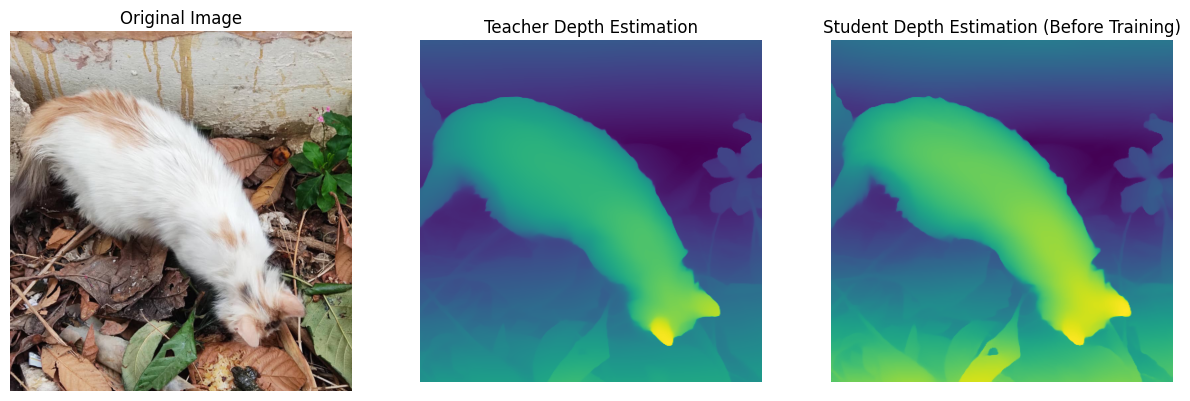

In [8]:
# Load image
image_path = "/content/test.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

input_tensor = transform(Image.fromarray(image)).unsqueeze(0).to("cuda")

# Set models to evaluation mode
teacher_model.eval() # Use the DepthModel instance
student_model.eval() # Use the DepthModel instance


with torch.no_grad():
    # Student prediction (before training) using the DepthModel instance
    student_output_before_tuple = student_model(input_tensor)
    student_depth_before = student_output_before_tuple[0] # Access predicted_depth from the tuple
    print(student_depth_before.shape)
    student_depth_before_training = student_depth_before.squeeze().cpu().numpy()
    print(student_depth_before_training.shape)

    # Teacher prediction using the DepthModel instance
    teacher_output_tuple = teacher_model(input_tensor)
    teacher_depth = teacher_output_tuple[0] # Access predicted_depth from the tuple
    teacher_depth = teacher_depth.squeeze().cpu().numpy()

#Befor training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_depth_before_training, cmap="viridis")
plt.title("Student Depth Estimation (Before Training)")
plt.axis("off")

plt.show()


### Run the Training

In [9]:
    # Run the training
mods = train_knowledge_distillation(
    teacher=teacher_model,
    student=student_model,
    dataloader=unlabeled_dataloader,
    criterion=distillation_criterion,
    optimizer=student_optimizer,
    epochs=num_epochs,
    device=device
)

print("Training complete. Student model saved at specified checkpoints.")


Starting Knowledge Distillation Training on cuda...
Epoch 1 finished. Avg Loss: 113.6410, Time: 12.89s
Epoch 2 finished. Avg Loss: 95.6377, Time: 12.83s
Epoch 3 finished. Avg Loss: 90.1348, Time: 12.42s
Epoch 4 finished. Avg Loss: 85.6607, Time: 12.96s
Epoch 5 finished. Avg Loss: 83.1425, Time: 12.84s
Epoch 6 finished. Avg Loss: 76.8662, Time: 12.39s
Epoch 7 finished. Avg Loss: 74.3199, Time: 12.37s
Epoch 8 finished. Avg Loss: 73.4119, Time: 12.47s
Epoch 9 finished. Avg Loss: 67.2010, Time: 12.49s
Epoch 10 finished. Avg Loss: 66.1741, Time: 13.08s
Epoch 11 finished. Avg Loss: 65.6813, Time: 14.16s
Epoch 12 finished. Avg Loss: 61.4071, Time: 12.66s
Epoch 13 finished. Avg Loss: 56.9808, Time: 13.03s
Epoch 14 finished. Avg Loss: 63.4410, Time: 12.63s
Epoch 15 finished. Avg Loss: 63.7896, Time: 14.33s
Epoch 16 finished. Avg Loss: 63.7659, Time: 12.70s
Epoch 17 finished. Avg Loss: 56.6085, Time: 12.53s
Epoch 18 finished. Avg Loss: 60.9794, Time: 12.45s
Epoch 19 finished. Avg Loss: 63.1638, 

# Evaluation

torch.Size([1, 378, 378])
(378, 378)


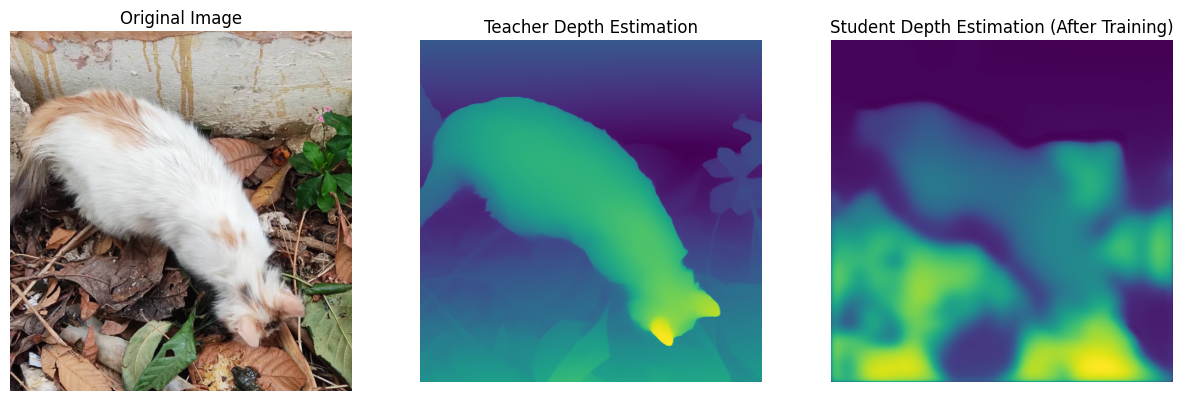

torch.Size([1, 378, 378])
(378, 378)
torch.Size([1, 378, 378])
(378, 378)
torch.Size([1, 378, 378])
(378, 378)


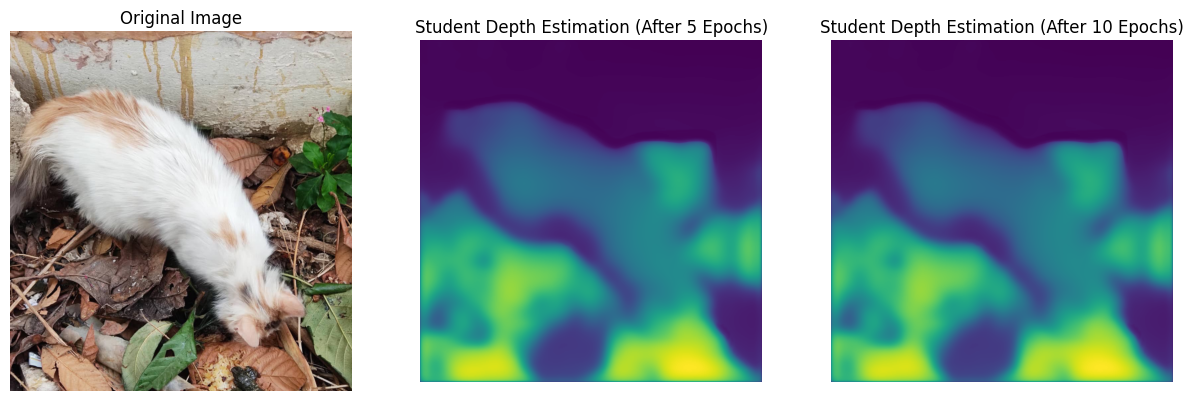

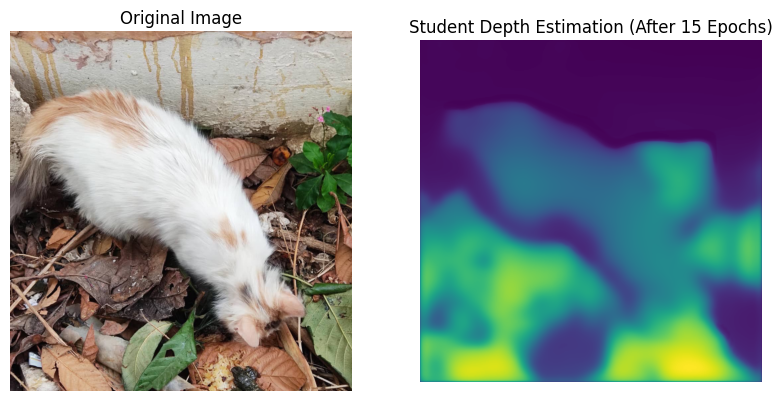

In [12]:
# Load image
image_path = "/content/test.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

input_tensor = transform(Image.fromarray(image)).unsqueeze(0).to("cuda")

# Set models to evaluation mode
teacher_model.eval() # Use the DepthModel instance
student_model.eval() # Use the DepthModel instance


with torch.no_grad():
    # Student prediction (before training) using the DepthModel instance
    student_output_before_tuple = student_model(input_tensor)
    student_depth_before = student_output_before_tuple[0] # Access predicted_depth from the tuple
    print(student_depth_before.shape)
    student_depth_before_training = student_depth_before.squeeze().cpu().numpy()
    print(student_depth_before_training.shape)

    # Teacher prediction using the DepthModel instance
    teacher_output_tuple = teacher_model(input_tensor)
    teacher_depth = teacher_output_tuple[0] # Access predicted_depth from the tuple
    teacher_depth = teacher_depth.squeeze().cpu().numpy()

#Befor training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_depth_before_training, cmap="viridis")
plt.title("Student Depth Estimation (After Training)")
plt.axis("off")

plt.show()

# Set models to evaluation mode - use the DepthModel instances
teacher_model.eval()
mods[0].eval()

with torch.no_grad():
    # Student prediction (after 5 epochs) using the DepthModel instance from mods
    student_output_after_5_tuple = mods[0](input_tensor)
    student_depth_after_5 = student_output_after_5_tuple[0] # Access predicted_depth from the tuple
    student_depth_after_training_5 = student_depth_after_5.squeeze().cpu().numpy()
    # Student prediction (after 10 epochs) using the DepthModel instance from mods
    student_output_after_10_tuple = mods[1](input_tensor)
    student_depth_after_10 = student_output_after_10_tuple[0] # Access predicted_depth from the tuple
    student_depth_after_training_10 = student_depth_after_10.squeeze().cpu().numpy()
    # Student prediction (after 15 epochs) using the DepthModel instance from mods
    student_output_after_15_tuple = mods[2](input_tensor)
    student_depth_after_15 = student_output_after_15_tuple[0] # Access predicted_depth from the tuple
    student_depth_after_training_15 = student_depth_after_15.squeeze().cpu().numpy()


# After Training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Student Depth Map (After 5 Epochs)
plt.subplot(1, 3, 2)
plt.imshow(student_depth_after_training_5, cmap="viridis")
plt.title("Student Depth Estimation (After 5 Epochs)")
plt.axis("off")

# Placeholder for Student After 10 Epochs
plt.subplot(1, 3, 3)
plt.imshow(student_depth_after_training_10, cmap="viridis") # Re-using for placeholder display
plt.title("Student Depth Estimation (After 10 Epochs)")
plt.axis("off")

plt.show()

# After Training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Student Depth Map (After 15 Epochs)
plt.subplot(1, 3, 2)
plt.imshow(student_depth_after_training_15, cmap="viridis")
plt.title("Student Depth Estimation (After 15 Epochs)")
plt.axis("off")


plt.show()